In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point, Polygon, LineString
import contextily as cx
import datetime as dt
import json
from joblib import Parallel, delayed
import joblib
import haversine as hs
pd.options.mode.chained_assignment = None  # default='warn'
from matplotlib.collections import LineCollection
import matplotlib.colors as mcol

from functions_file import *
print(testfunction(4))

16


In [2]:
# check number of available processors 
joblib.cpu_count()

def plot_line_trajectories(df_all,mode='Bus',axes=['time','speed','trv_dist'], exclude_motorcycle = False, exp_ids = ['0']):
    #axes_dict = dict{'speed':1,'distance':2,'time':0} 
    df_all = df_all[df_all.exp_id.isin(exp_ids)]
    if mode=='all':
        if exclude_motorcycle:
            mode_df = df_all[~(df_all.type == 'Motorcycle')]
        else:
            mode_df = df_all
    else:
        mode_df = df_all[df_all['type']==mode]

    all_list = []
    for val in axes:
        all_list.append(mode_df.groupby('unique_id')[val].apply(list))
    fig, ax = plt.subplots(figsize=(12, 8))
    norm = plt.Normalize(0, 50)
    psize=1
    time_speed_trvdist = list(zip(all_list[0],all_list[1],all_list[2]))
    cmap = mcol.LinearSegmentedColormap.from_list("", ["red","yellow","green"])
    for x_y in time_speed_trvdist:
        points = np.array([x_y[0], x_y[2]]).T.reshape(-1, 1, 2) #[x-x_y[2][0] for x in x_y[2]]
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        lc = LineCollection(segments, linewidths=psize, cmap=cmap, norm=norm)
        lc.set_array(x_y[1])
        im = ax.add_collection(lc)
        ax.autoscale()


### Outline
1. Prep
4. Calculate MS values
5. Make a loop detector and calculate values
5. 3D mMFD attempt

### 1. Prep

In [3]:
#carmodes = ['Car0070','Car0060','Car0050','Car0045','Car0040','Car0035','Car0030','Car0025','Car0020','Car0010'] # car penetration rates as modes
carmodes = ['Car0050'] # car penetration rates as modes
lengths = {'Car':5,'Bus':12.5,'Taxi':5,'Motorcycle':2.5,'Medium Vehicle':5.83,'Heavy Vehicle':12.5}
DOW_exp_dict = [['Wed',[1,2,3,4,5]],['Mon',[6,7,9,10]],['Tue',[11,12,13,14,15]],['Thu',[17,18,19,20]]]
polygons = pd.read_csv('../data/polygons11.csv')
polygons = polygons.drop([4])

In [4]:
polygon_name = 'polygon_r0'
POLYGON = get_polygon(polygon_name,polygons)
POLYGON

{'polygon': '0',
 'name': 'polygon_r0',
 'length': 0.105,
 'lanes': 3.0,
 'direction': 170.0,
 'busstops': 0.0,
 'seplane': 1.0,
 'comment': '2 + cab/bus/motorcycle lane',
 'complexity': 1.0,
 'road_rank': 0.0,
 'coords': <shapely.geometry.polygon.Polygon at 0x141f6b39210>}

In [5]:
#lanes-file: header are OL(oben links),OR,UR(unten rechts) and UL; every line contains the 4 points, 
#x,y seperated by ,; points separated by a ;
#one line for every lane
lanes_coords = pd.read_csv('../data/p11_Lanes.csv',sep=';')
lanes_df = pd.DataFrame(columns = ['lane_coords'])
for id_,lane in lanes_coords.iterrows():
    lanes_df.loc[id_] = Polygon([[float(lane.OL.split(',')[1]),float(lane.OL.split(',')[0])],
                             [float(lane.OR.split(',')[1]),float(lane.OR.split(',')[0])],
                             [float(lane.UR.split(',')[1]),float(lane.UR.split(',')[0])],
                             [float(lane.UL.split(',')[1]),float(lane.UL.split(',')[0])]])

In [6]:
poly_full,POLYGON = load_data('polygon_r11', polygons)

Polygon 4 (road segment 4) is dropped, as it is a different kind of road segment; it is multiple blocks long. Polygons 0-3 and 5-11 are used (11 segments). In the plots in the thesis the polygons 4-10 equate to polygons 5-11 in the notebooks.

In [7]:
#what we have: lane coordinates at the boundary for each lane, next step: filter the data according to the lanes, 
#do a point plot, do a x-t
data_per_lane =  []
for id_,lane_polygon in lanes_df.iterrows():
    lane_df_dat = poly_full[poly_full.geometry.within(lane_polygon['lane_coords'])]
    data_per_lane.append(lane_df_dat)

In [37]:
data_per_lane[0][data_per_lane[0].unique_id==15001325]

,unique_id,type,exp_id,DOW,ST,ET,DOY,track_id,time,speed,trv_dist,timestamp,geometry
1372617,15001325,Motorcycle,15,Tue,10.0,10.5,2018-10-30,1325,90.56,18.1175,125.886903,2018-10-30 10:01:30.560,POINT (23.73102 37.98240)
1372619,15001325,Motorcycle,15,Tue,10.0,10.5,2018-10-30,1325,90.88,17.5861,127.531394,2018-10-30 10:01:30.880,POINT (23.73100 37.98241)
1372621,15001325,Motorcycle,15,Tue,10.0,10.5,2018-10-30,1325,91.20,16.8554,129.034786,2018-10-30 10:01:31.200,POINT (23.73100 37.98242)
1372622,15001325,Motorcycle,15,Tue,10.0,10.5,2018-10-30,1325,91.36,16.4419,129.783590,2018-10-30 10:01:31.360,POINT (23.73099 37.98242)
1372623,15001325,Motorcycle,15,Tue,10.0,10.5,2018-10-30,1325,91.52,16.0190,130.489200,2018-10-30 10:01:31.520,POINT (23.73099 37.98243)
1372624,15001325,Motorcycle,15,Tue,10.0,10.5,2018-10-30,1325,91.68,15.5878,131.194833,2018-10-30 10:01:31.680,POINT (23.73098 37.98244)
1372625,15001325,Motorcycle,15,Tue,10.0,10.5,2018-10-30,1325,91.84,15.1508,131.851472,2018-10-30 10:01:31.840,POINT (23.73098 37.98244)
1372626,15001325,Motorcycle,15,Tue,10.0,10.5,2018-10-30,1325,92.00,14.7348,132.557121,2018-10-30 10:01:32.000,POINT (23.73097 37.98244)
1372627,15001325,Motorcycle,15,Tue,10.0,10.5,2018-10-30,1325,92.16,14.3682,133.213756,2018-10-30 10:01:32.160,POINT (23.73097 37.98245)
1372628,15001325,Motorcycle,15,Tue,10.0,10.5,2018-10-30,1325,92.32,14.0400,133.778285,2018-10-30 10:01:32.320,POINT (23.73096 37.98245)


In [38]:
for ldf in data_per_lane:
    ldf['link_dist'] = get_distance_from_segment_start(ldf,list(POLYGON['coords'].exterior.coords))

In [39]:
data_per_lane[0].columns

Index(['unique_id', 'type', 'exp_id', 'DOW', 'ST', 'ET', 'DOY', 'track_id',
       'time', 'speed', 'trv_dist', 'timestamp', 'geometry', 'link_dist'],
      dtype='object')

In [48]:
counter = -1
for lane in data_per_lane:
    counter+=1
    lane.drop(['DOW','track_id','timestamp'],axis=1).to_file('../output/shapefiles/lanes_r11/lane_%s.shp'%(counter), driver='ESRI Shapefile')

C:\Users\ga59com\Anaconda3\envs\trb23wC\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
C:\Users\ga59com\Anaconda3\envs\trb23wC\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
C:\Users\ga59com\Anaconda3\envs\trb23wC\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
C:\Users\ga59com\Anaconda3\envs\trb23wC\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
 

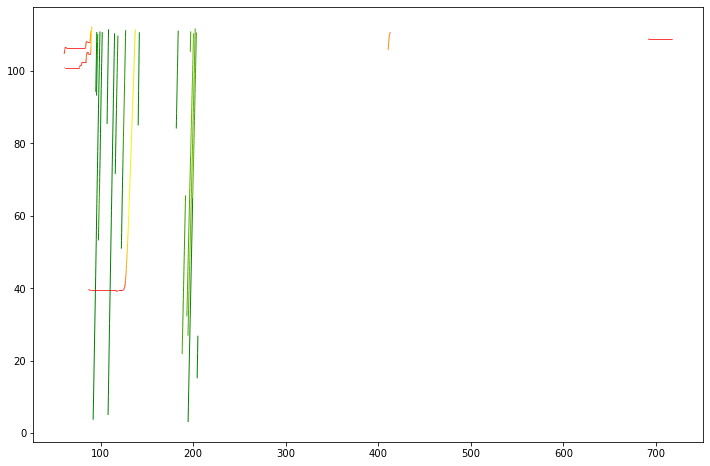

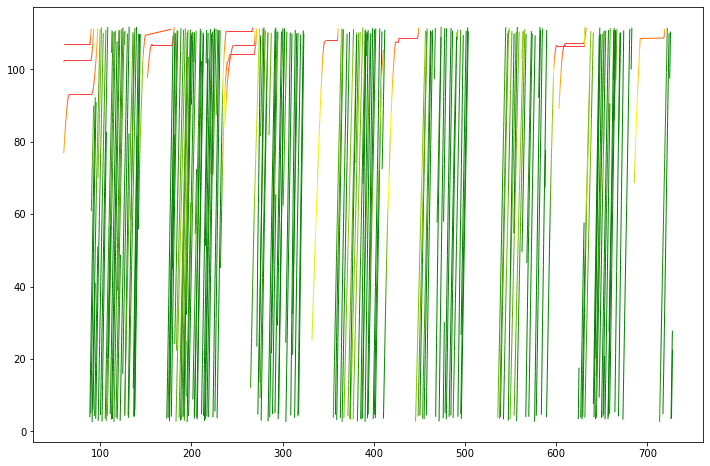

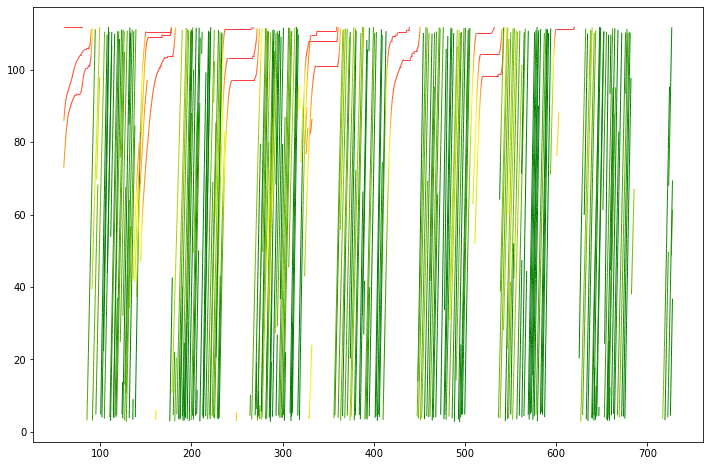

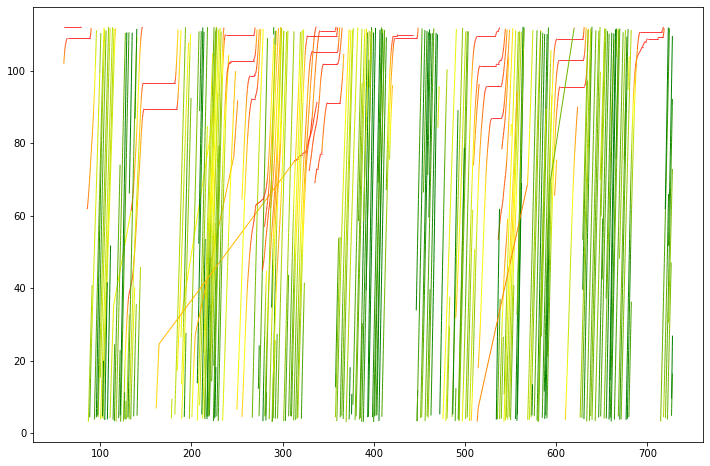

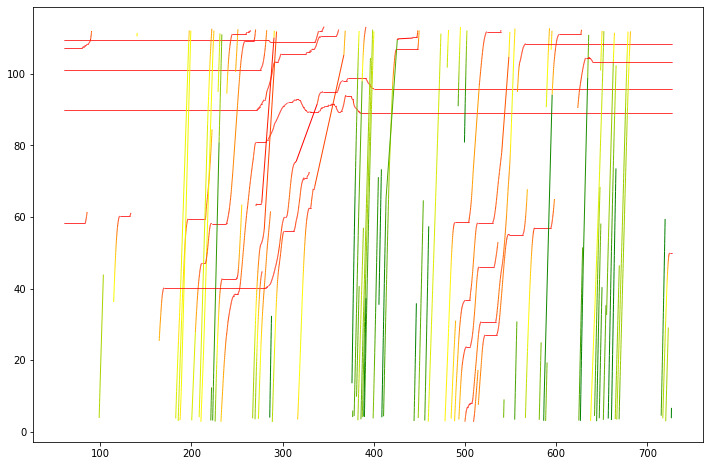

In [45]:
for lane_dfs in data_per_lane:
    plot_line_trajectories(lane_dfs,mode='all',axes=['time','speed','link_dist'], exclude_motorcycle = True, exp_ids=[0,1])

### 2. Process MS Data and calculate v, q, k

The car modes ('cars') are calculated separately from all other considered modes ('regular') to account for the various penetration rates.

In [4]:
######################
# CALCULATE VALUES - based in timestamp
######################
for version in ['regular','cars']: 
    save = 'on'
    for polygon_name in polygons.name:
        
        # load data
        waypoints_w_dist_mode,POLYGON = load_data(polygon_name,polygons)
        # set time interval
        step = dt.timedelta(seconds=5) #change to 30 again
        # select version
        save_data = []
        if 'cars'==version:
            modes = carmodes
            savefilename = '../output/data_flow_with_parked_5s/flow_data_MS_%s_cars.json'%(POLYGON['name'])
        if 'regular'==version:
            modes = np.append( waypoints_w_dist_mode['type'].unique(), ['all'])
            savefilename = '../output/data_flow_with_parked_5s/flow_data_MS_%s.json'%(POLYGON['name'])

        # 0. per mode
        for mode in modes:

            # 1. select data (the functions are in functions_file.py)
            mode_section,_ = get_mode_section(mode,carmodes,waypoints_w_dist_mode,lengths)
            if not len(mode_section)>0:
                print('No data for ',mode)
                continue
            # 2. process each experiment
            for DOW,day in DOW_exp_dict:

                # regular version
                '''for exp in day:
                    exp_results = process_exp_MS_Edie([mode_section,mode,POLYGON,day,DOW,exp,step])
                    if (exp_results is not None):
                        save_data.append(exp_results)'''
                # parallel version (no output)
                t1 = dt.datetime.now()
                # n_jobs = -2 --> all but one of the available processors are used
                print('Polygon: ',polygon_name,', length: ',POLYGON['length'])
                day_results = Parallel(n_jobs=-2)(delayed(process_exp_MS_Edie)([mode_section,mode,POLYGON,day,DOW,exp,step]) for exp in day) 
                # save
                print('Duration:',dt.datetime.now()-t1,'--> ',DOW,'done')
                for exp_results in day_results:
                    if (exp_results is not None):
                        save_data.append(exp_results)

        # 4. save data
        if save=='on':
            with open(savefilename, 'w', encoding='utf-8') as f: 
                json.dump(save_data, f, default=str)
        save_data = pd.DataFrame(save_data,columns=['polygon','mode','day','DOW','exp_id','speeds','densities','flows','times'])
        display(save_data.head(2))

Starting with Car.
Polygon:  polygon_r0 , length:  0.105
Duration: 0:01:59.946234 -->  Wed done
Polygon:  polygon_r0 , length:  0.105
Duration: 0:01:30.648460 -->  Mon done
Polygon:  polygon_r0 , length:  0.105
Duration: 0:01:57.595480 -->  Tue done
Polygon:  polygon_r0 , length:  0.105
Duration: 0:01:38.025255 -->  Thu done
Starting with Heavy Vehicle.
Polygon:  polygon_r0 , length:  0.105
Duration: 0:00:06.542820 -->  Wed done
Polygon:  polygon_r0 , length:  0.105
Duration: 0:00:04.732117 -->  Mon done
Polygon:  polygon_r0 , length:  0.105
Duration: 0:00:03.808193 -->  Tue done
Polygon:  polygon_r0 , length:  0.105
Duration: 0:00:03.677691 -->  Thu done
Starting with Motorcycle.
Polygon:  polygon_r0 , length:  0.105
Duration: 0:00:32.083047 -->  Wed done
Polygon:  polygon_r0 , length:  0.105
Duration: 0:00:26.713864 -->  Mon done
Polygon:  polygon_r0 , length:  0.105
Duration: 0:00:32.282960 -->  Tue done
Polygon:  polygon_r0 , length:  0.105
Duration: 0:00:26.181228 -->  Thu done
St

,polygon,mode,day,DOW,exp_id,speeds,densities,flows,times
0,polygon_r0,Car,"[1, 2, 3, 4, 5]",Wed,1,"[44.128442993561826, 32.86851848241265, 29.371...","[13.714285714285692, 22.857142857142847, 31.99...","[605.1900753402755, 751.2804224551459, 939.889...","[2018-10-24 08:31:13, 2018-10-24 08:31:18, 201..."
1,polygon_r0,Car,"[1, 2, 3, 4, 5]",Wed,2,"[55.916483724675, 50.51471701371549, 38.730435...","[20.190476190476165, 12.571428571428573, 11.80...","[1128.9804332981985, 635.0421567438519, 457.38...","[2018-10-24 09:01:00, 2018-10-24 09:01:05, 201..."


Starting with Car.
Polygon:  polygon_r1 , length:  0.105
Duration: 0:01:24.842097 -->  Wed done
Polygon:  polygon_r1 , length:  0.105
Duration: 0:01:11.349946 -->  Mon done
Polygon:  polygon_r1 , length:  0.105
Duration: 0:01:29.231298 -->  Tue done
Polygon:  polygon_r1 , length:  0.105
Duration: 0:01:17.606477 -->  Thu done
Starting with Bus.
Polygon:  polygon_r1 , length:  0.105
Duration: 0:00:26.180090 -->  Wed done
Polygon:  polygon_r1 , length:  0.105
Duration: 0:00:21.789561 -->  Mon done
Polygon:  polygon_r1 , length:  0.105
Duration: 0:00:26.456833 -->  Tue done
Polygon:  polygon_r1 , length:  0.105
Duration: 0:00:19.388460 -->  Thu done
Starting with Taxi.
Polygon:  polygon_r1 , length:  0.105
Duration: 0:00:51.739193 -->  Wed done
Polygon:  polygon_r1 , length:  0.105
Duration: 0:00:42.317039 -->  Mon done
Polygon:  polygon_r1 , length:  0.105
Duration: 0:00:51.041642 -->  Tue done
Polygon:  polygon_r1 , length:  0.105
Duration: 0:00:42.890979 -->  Thu done
Starting with Moto

,polygon,mode,day,DOW,exp_id,speeds,densities,flows,times
0,polygon_r1,Car,"[1, 2, 3, 4, 5]",Wed,1,"[26.961794781169623, 27.623902683798143, 29.18...","[137.5238095238095, 109.71428571428562, 88.761...","[3707.888729905612, 3030.736751593851, 2590.31...","[2018-10-24 08:31:00, 2018-10-24 08:31:05, 201..."
1,polygon_r1,Car,"[1, 2, 3, 4, 5]",Wed,2,"[0.09094217716448479, 18.05699407182771, 27.48...","[11.809523809523794, 33.523809523809526, 70.09...","[1.0739838065139142, 605.33922983651, 1926.520...","[2018-10-24 09:01:00, 2018-10-24 09:01:05, 201..."


Starting with Bus.
Polygon:  polygon_r2 , length:  0.084
Duration: 0:00:02.110321 -->  Wed done
Polygon:  polygon_r2 , length:  0.084
Duration: 0:00:01.413131 -->  Mon done
Polygon:  polygon_r2 , length:  0.084
Duration: 0:00:02.113850 -->  Tue done
Polygon:  polygon_r2 , length:  0.084
Duration: 0:00:02.169092 -->  Thu done
Starting with Car.
Polygon:  polygon_r2 , length:  0.084
Duration: 0:01:00.899390 -->  Wed done
Polygon:  polygon_r2 , length:  0.084
Duration: 0:00:48.735601 -->  Mon done
Polygon:  polygon_r2 , length:  0.084
Duration: 0:01:01.244150 -->  Tue done
Polygon:  polygon_r2 , length:  0.084
Duration: 0:00:49.701309 -->  Thu done
Starting with Medium Vehicle.
Polygon:  polygon_r2 , length:  0.084
Duration: 0:00:07.602241 -->  Wed done
Polygon:  polygon_r2 , length:  0.084
Duration: 0:00:06.585316 -->  Mon done
Polygon:  polygon_r2 , length:  0.084
Duration: 0:00:07.963240 -->  Tue done
Polygon:  polygon_r2 , length:  0.084
Duration: 0:00:07.232357 -->  Thu done
Starting

,polygon,mode,day,DOW,exp_id,speeds,densities,flows,times
0,polygon_r2,Bus,"[1, 2, 3, 4, 5]",Wed,1,"[0.4525052499343683, nan, nan, nan, nan, nan, ...","[14.761904761904741, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[6.679839403793046, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[2018-10-24 08:31:00, 2018-10-24 08:31:10, 201..."
1,polygon_r2,Bus,"[1, 2, 3, 4, 5]",Wed,2,"[18.173627855215226, 11.045702897182453, 1.916...","[12.380952380952284, 14.285714285714318, 14.28...","[225.0068210645677, 157.7957556740354, 27.3805...","[2018-10-24 09:04:47, 2018-10-24 09:04:52, 201..."


Starting with Car.
Polygon:  polygon_r3 , length:  0.09
Duration: 0:00:30.719018 -->  Wed done
Polygon:  polygon_r3 , length:  0.09
Duration: 0:00:25.002233 -->  Mon done
Polygon:  polygon_r3 , length:  0.09
Duration: 0:00:30.095077 -->  Tue done
Polygon:  polygon_r3 , length:  0.09
Duration: 0:00:25.194991 -->  Thu done
Starting with Taxi.
Polygon:  polygon_r3 , length:  0.09
Duration: 0:00:16.045070 -->  Wed done
Polygon:  polygon_r3 , length:  0.09
Duration: 0:00:13.107737 -->  Mon done
Polygon:  polygon_r3 , length:  0.09
Duration: 0:00:16.278089 -->  Tue done
Polygon:  polygon_r3 , length:  0.09
Duration: 0:00:13.627563 -->  Thu done
Starting with Medium Vehicle.
Polygon:  polygon_r3 , length:  0.09
Duration: 0:00:05.407171 -->  Wed done
Polygon:  polygon_r3 , length:  0.09
Duration: 0:00:04.035225 -->  Mon done
Polygon:  polygon_r3 , length:  0.09
Duration: 0:00:04.940229 -->  Tue done
Polygon:  polygon_r3 , length:  0.09
Duration: 0:00:04.229130 -->  Thu done
Starting with Motor

,polygon,mode,day,DOW,exp_id,speeds,densities,flows,times
0,polygon_r3,Car,"[1, 2, 3, 4, 5]",Wed,1,"[53.06919623584138, 14.909876147213668, nan, 1...","[15.555555555555541, 5.777777777777773, 0, 14....","[825.5208303353096, 86.14595107279001, 0, 232....","[2018-10-24 08:31:00, 2018-10-24 08:31:05, 201..."
1,polygon_r3,Car,"[1, 2, 3, 4, 5]",Wed,2,"[30.753383033916776, 30.02762678953126, 27.315...","[96.88888888888876, 55.99999999999995, 44.8888...","[2979.6611117305993, 1681.5471002137492, 1226....","[2018-10-24 09:01:00, 2018-10-24 09:01:05, 201..."


Starting with Medium Vehicle.
Polygon:  polygon_r5 , length:  0.075
Duration: 0:00:04.852224 -->  Wed done
Polygon:  polygon_r5 , length:  0.075
Duration: 0:00:04.442574 -->  Mon done
Polygon:  polygon_r5 , length:  0.075
Duration: 0:00:05.298490 -->  Tue done
Polygon:  polygon_r5 , length:  0.075
Duration: 0:00:04.969462 -->  Thu done
Starting with Car.
Polygon:  polygon_r5 , length:  0.075
Duration: 0:00:57.882490 -->  Wed done
Polygon:  polygon_r5 , length:  0.075
Duration: 0:00:47.966061 -->  Mon done
Polygon:  polygon_r5 , length:  0.075
Duration: 0:01:00.250823 -->  Tue done
Polygon:  polygon_r5 , length:  0.075
Duration: 0:00:46.839899 -->  Thu done
Starting with Motorcycle.
Polygon:  polygon_r5 , length:  0.075
Duration: 0:00:14.975208 -->  Wed done
Polygon:  polygon_r5 , length:  0.075
Duration: 0:00:12.874760 -->  Mon done
Polygon:  polygon_r5 , length:  0.075
Duration: 0:00:15.959120 -->  Tue done
Polygon:  polygon_r5 , length:  0.075
Duration: 0:00:13.190473 -->  Thu done
S

,polygon,mode,day,DOW,exp_id,speeds,densities,flows,times
0,polygon_r5,Medium Vehicle,"[1, 2, 3, 4, 5]",Wed,1,"[21.511603557931508, 33.08575680581045, nan, n...","[15.999999999999993, 16.355555555555522, 0, 0,...","[344.18565692690396, 541.135933535032, 0, 0, 0...","[2018-10-24 08:31:04, 2018-10-24 08:31:09, 201..."
1,polygon_r5,Medium Vehicle,"[1, 2, 3, 4, 5]",Wed,2,"[4.2024422435687905, 4.434929077169253, 1.5183...","[13.333333333333334, 15.999999999999993, 15.99...","[56.03256324758388, 70.95886523470801, 24.2940...","[2018-10-24 09:01:49, 2018-10-24 09:01:54, 201..."


Starting with Car.
Polygon:  polygon_r6 , length:  0.1305
Duration: 0:00:59.722773 -->  Wed done
Polygon:  polygon_r6 , length:  0.1305
Duration: 0:00:48.196217 -->  Mon done
Polygon:  polygon_r6 , length:  0.1305
Duration: 0:01:01.013791 -->  Tue done
Polygon:  polygon_r6 , length:  0.1305
Duration: 0:00:49.120922 -->  Thu done
Starting with Taxi.
Polygon:  polygon_r6 , length:  0.1305
Duration: 0:00:25.221064 -->  Wed done
Polygon:  polygon_r6 , length:  0.1305
Duration: 0:00:20.560346 -->  Mon done
Polygon:  polygon_r6 , length:  0.1305
Duration: 0:00:25.345547 -->  Tue done
Polygon:  polygon_r6 , length:  0.1305
Duration: 0:00:21.281094 -->  Thu done
Starting with Medium Vehicle.
Polygon:  polygon_r6 , length:  0.1305
Duration: 0:00:04.696926 -->  Wed done
Polygon:  polygon_r6 , length:  0.1305
Duration: 0:00:03.802572 -->  Mon done
Polygon:  polygon_r6 , length:  0.1305
Duration: 0:00:04.883634 -->  Tue done
Polygon:  polygon_r6 , length:  0.1305
Duration: 0:00:04.221105 -->  Thu 

,polygon,mode,day,DOW,exp_id,speeds,densities,flows,times
0,polygon_r6,Car,"[1, 2, 3, 4, 5]",Wed,1,"[37.507223316225776, 25.865284452486595, 13.79...","[30.038314176245184, 50.268199233716466, 73.56...","[1126.6537578513787, 1300.201272094345, 1015.1...","[2018-10-24 08:31:00, 2018-10-24 08:31:05, 201..."
1,polygon_r6,Car,"[1, 2, 3, 4, 5]",Wed,2,"[40.16644523522227, 38.47945405179842, 38.3320...","[53.63984674329502, 53.33333333333331, 37.7011...","[2154.521966640275, 2052.2375494292482, 1445.1...","[2018-10-24 09:01:00, 2018-10-24 09:01:05, 201..."


Starting with Medium Vehicle.
Polygon:  polygon_r7 , length:  0.095
Duration: 0:00:03.950845 -->  Wed done
Polygon:  polygon_r7 , length:  0.095
Duration: 0:00:03.098898 -->  Mon done
Polygon:  polygon_r7 , length:  0.095
Duration: 0:00:04.549223 -->  Tue done
Polygon:  polygon_r7 , length:  0.095
Duration: 0:00:03.447210 -->  Thu done
Starting with Car.
Polygon:  polygon_r7 , length:  0.095
Duration: 0:00:32.214697 -->  Wed done
Polygon:  polygon_r7 , length:  0.095
Duration: 0:00:26.309419 -->  Mon done
Polygon:  polygon_r7 , length:  0.095
Duration: 0:00:32.276740 -->  Tue done
Polygon:  polygon_r7 , length:  0.095
Duration: 0:00:27.769064 -->  Thu done
Starting with Taxi.
Polygon:  polygon_r7 , length:  0.095
Duration: 0:00:08.814804 -->  Wed done
Polygon:  polygon_r7 , length:  0.095
Duration: 0:00:08.188390 -->  Mon done
Polygon:  polygon_r7 , length:  0.095
Duration: 0:00:09.516094 -->  Tue done
Polygon:  polygon_r7 , length:  0.095
Duration: 0:00:07.841020 -->  Thu done
Startin

,polygon,mode,day,DOW,exp_id,speeds,densities,flows,times
0,polygon_r7,Medium Vehicle,"[1, 2, 3, 4, 5]",Wed,1,"[0.6071709410130989, 3.2099280665115133, 1.835...","[12.210526315789513, 12.631578947368375, 12.63...","[7.413876753423126, 40.546459787513704, 23.184...","[2018-10-24 08:33:48, 2018-10-24 08:33:53, 201..."
1,polygon_r7,Medium Vehicle,"[1, 2, 3, 4, 5]",Wed,2,"[29.1916217895857, 40.93187633408242, nan, nan...","[12.631578947368434, 10.666666666666687, 0, 0,...","[368.73627523687236, 436.60668089688, 0, 0, 0,...","[2018-10-24 09:01:00, 2018-10-24 09:01:05, 201..."


Starting with Car.
Polygon:  polygon_r8 , length:  0.079
Duration: 0:00:26.611984 -->  Wed done
Polygon:  polygon_r8 , length:  0.079
Duration: 0:00:23.448553 -->  Mon done
Polygon:  polygon_r8 , length:  0.079
Duration: 0:00:28.143719 -->  Tue done
Polygon:  polygon_r8 , length:  0.079
Duration: 0:00:23.587731 -->  Thu done
Starting with Taxi.
Polygon:  polygon_r8 , length:  0.079
Duration: 0:00:13.151715 -->  Wed done
Polygon:  polygon_r8 , length:  0.079
Duration: 0:00:11.589743 -->  Mon done
Polygon:  polygon_r8 , length:  0.079
Duration: 0:00:14.252291 -->  Tue done
Polygon:  polygon_r8 , length:  0.079
Duration: 0:00:12.102380 -->  Thu done
Starting with Medium Vehicle.
Polygon:  polygon_r8 , length:  0.079
Duration: 0:00:02.741854 -->  Wed done
Polygon:  polygon_r8 , length:  0.079
Duration: 0:00:02.394134 -->  Mon done
Polygon:  polygon_r8 , length:  0.079
Duration: 0:00:03.282982 -->  Tue done
Polygon:  polygon_r8 , length:  0.079
Duration: 0:00:02.905713 -->  Thu done
Startin

,polygon,mode,day,DOW,exp_id,speeds,densities,flows,times
0,polygon_r8,Car,"[1, 2, 3, 4, 5]",Wed,1,"[30.98638759536865, 24.519748427691592, 22.682...","[27.84810126582271, 46.58227848101265, 34.9367...","[862.9120596178589, 1142.1857495431018, 792.43...","[2018-10-24 08:31:00, 2018-10-24 08:31:05, 201..."
1,polygon_r8,Car,"[1, 2, 3, 4, 5]",Wed,2,"[38.312757360450355, 41.43946558496839, 43.028...","[39.999999999999936, 48.607594936708814, 34.43...","[1532.5102944180117, 2014.2727575478286, 1481....","[2018-10-24 09:01:00, 2018-10-24 09:01:05, 201..."


Starting with Car.
Polygon:  polygon_r9 , length:  0.093
Duration: 0:00:54.151253 -->  Wed done
Polygon:  polygon_r9 , length:  0.093
Duration: 0:00:43.703821 -->  Mon done
Polygon:  polygon_r9 , length:  0.093
Duration: 0:00:54.626222 -->  Tue done
Polygon:  polygon_r9 , length:  0.093
Duration: 0:00:44.811242 -->  Thu done
Starting with Motorcycle.
Polygon:  polygon_r9 , length:  0.093
Duration: 0:00:15.441757 -->  Wed done
Polygon:  polygon_r9 , length:  0.093
Duration: 0:00:13.363218 -->  Mon done
Polygon:  polygon_r9 , length:  0.093
Duration: 0:00:15.561826 -->  Tue done
Polygon:  polygon_r9 , length:  0.093
Duration: 0:00:12.929501 -->  Thu done
Starting with Medium Vehicle.
Polygon:  polygon_r9 , length:  0.093
Duration: 0:00:07.866959 -->  Wed done
Polygon:  polygon_r9 , length:  0.093
Duration: 0:00:06.475913 -->  Mon done
Polygon:  polygon_r9 , length:  0.093
Duration: 0:00:08.403481 -->  Tue done
Polygon:  polygon_r9 , length:  0.093
Duration: 0:00:07.055855 -->  Thu done
S

,polygon,mode,day,DOW,exp_id,speeds,densities,flows,times
0,polygon_r9,Car,"[1, 2, 3, 4, 5]",Wed,1,"[0.06817200371375166, 2.529882709796371, 6.675...","[212.04301075268802, 203.01075268817192, 168.6...","[14.45539691650733, 513.5933931285533, 1125.53...","[2018-10-24 08:31:00, 2018-10-24 08:31:05, 201..."
1,polygon_r9,Car,"[1, 2, 3, 4, 5]",Wed,2,"[1.2449776425622783, 0.7797480219036961, 0.014...","[214.19354838709657, 229.67741935483858, 246.0...","[266.6661789230168, 179.09051341788106, 3.5454...","[2018-10-24 09:01:00, 2018-10-24 09:01:05, 201..."


Starting with Car.
Polygon:  polygon_r10 , length:  0.092
Duration: 0:01:21.867409 -->  Wed done
Polygon:  polygon_r10 , length:  0.092
Duration: 0:01:08.091191 -->  Mon done
Polygon:  polygon_r10 , length:  0.092
Duration: 0:01:24.628880 -->  Tue done
Polygon:  polygon_r10 , length:  0.092
Duration: 0:01:09.406591 -->  Thu done
Starting with Taxi.
Polygon:  polygon_r10 , length:  0.092
Duration: 0:00:15.191477 -->  Wed done
Polygon:  polygon_r10 , length:  0.092
Duration: 0:00:13.795793 -->  Mon done
Polygon:  polygon_r10 , length:  0.092
Duration: 0:00:17.016789 -->  Tue done
Polygon:  polygon_r10 , length:  0.092
Duration: 0:00:13.473191 -->  Thu done
Starting with Motorcycle.
Polygon:  polygon_r10 , length:  0.092
Duration: 0:00:16.633777 -->  Wed done
Polygon:  polygon_r10 , length:  0.092
Duration: 0:00:14.513315 -->  Mon done
Polygon:  polygon_r10 , length:  0.092
Duration: 0:00:16.724145 -->  Tue done
Polygon:  polygon_r10 , length:  0.092
Duration: 0:00:15.030623 -->  Thu done

,polygon,mode,day,DOW,exp_id,speeds,densities,flows,times
0,polygon_r10,Car,"[1, 2, 3, 4, 5]",Wed,1,"[3.373741377928196, 1.7079941544905708, 1.1021...","[259.56521739130415, 306.086956521739, 324.782...","[875.7059141839702, 522.7947325049397, 357.953...","[2018-10-24 08:31:00, 2018-10-24 08:31:05, 201..."
1,polygon_r10,Car,"[1, 2, 3, 4, 5]",Wed,2,"[4.8740519751108256, 8.387160639197463, nan, n...","[26.52173913043478, 22.608695652173896, 0, 0, ...","[129.26833499206973, 189.62276227750772, 0, 0,...","[2018-10-24 09:01:00, 2018-10-24 09:01:05, 201..."


Starting with Bus.
Polygon:  polygon_r11 , length:  0.121
Duration: 0:00:16.982381 -->  Wed done
Polygon:  polygon_r11 , length:  0.121
Duration: 0:00:14.547432 -->  Mon done
Polygon:  polygon_r11 , length:  0.121
Duration: 0:00:18.215422 -->  Tue done
Polygon:  polygon_r11 , length:  0.121
Duration: 0:00:14.120953 -->  Thu done
Starting with Taxi.
Polygon:  polygon_r11 , length:  0.121
Duration: 0:00:39.167419 -->  Wed done
Polygon:  polygon_r11 , length:  0.121
Duration: 0:00:32.354257 -->  Mon done
Polygon:  polygon_r11 , length:  0.121
Duration: 0:00:39.333439 -->  Tue done
Polygon:  polygon_r11 , length:  0.121
Duration: 0:00:31.906796 -->  Thu done
Starting with Motorcycle.
Polygon:  polygon_r11 , length:  0.121
Duration: 0:00:36.113931 -->  Wed done
Polygon:  polygon_r11 , length:  0.121
Duration: 0:00:28.617939 -->  Mon done
Polygon:  polygon_r11 , length:  0.121
Duration: 0:00:34.458360 -->  Tue done
Polygon:  polygon_r11 , length:  0.121
Duration: 0:00:30.157104 -->  Thu done

,polygon,mode,day,DOW,exp_id,speeds,densities,flows,times
0,polygon_r11,Bus,"[1, 2, 3, 4, 5]",Wed,1,"[1.8069573126022487, 0.0, 0.0, 0.0, 0.42452205...","[29.752066115702508, 30.743801652892525, 29.75...","[53.760713432794226, 0.0, 0.0, 0.0, 12.6304082...","[2018-10-24 08:31:00, 2018-10-24 08:31:05, 201..."
1,polygon_r11,Bus,"[1, 2, 3, 4, 5]",Wed,2,"[0.0, 0.0, 0.0, 7.355525896753648, 8.279509930...","[20.495867768595016, 19.834710743801644, 19.83...","[0.0, 0.0, 0.0, 204.2526199429112, 254.5436110...","[2018-10-24 09:01:00, 2018-10-24 09:01:05, 201..."


Starting with Car0050.
Polygon:  polygon_r0 , length:  0.105
Duration: 0:01:00.062796 -->  Wed done
Polygon:  polygon_r0 , length:  0.105
Duration: 0:00:48.085894 -->  Mon done
Polygon:  polygon_r0 , length:  0.105
Duration: 0:00:58.882020 -->  Tue done
Polygon:  polygon_r0 , length:  0.105
Duration: 0:00:48.595418 -->  Thu done


,polygon,mode,day,DOW,exp_id,speeds,densities,flows,times
0,polygon_r0,Car0050,"[1, 2, 3, 4, 5]",Wed,1,"[48.6622117348544, 50.32550489042215, nan, nan...","[9.904761904761896, 9.650793650793716, 0, 0, 1...","[481.9876209928432, 485.6810630694742, 0, 0, 5...","[2018-10-24 08:32:50, 2018-10-24 08:32:55, 201..."
1,polygon_r0,Car0050,"[1, 2, 3, 4, 5]",Wed,2,"[33.11059304352822, 16.7149461695102, 1.615724...","[11.047619047619083, 11.80952380952383, 11.428...","[365.79321838564624, 197.39555476373985, 18.46...","[2018-10-24 09:02:33, 2018-10-24 09:02:38, 201..."


Starting with Car0050.
Polygon:  polygon_r1 , length:  0.105
Duration: 0:00:42.648062 -->  Wed done
Polygon:  polygon_r1 , length:  0.105
Duration: 0:00:35.936483 -->  Mon done
Polygon:  polygon_r1 , length:  0.105
Duration: 0:00:44.433731 -->  Tue done
Polygon:  polygon_r1 , length:  0.105
Duration: 0:00:36.217398 -->  Thu done


,polygon,mode,day,DOW,exp_id,speeds,densities,flows,times
0,polygon_r1,Car0050,"[1, 2, 3, 4, 5]",Wed,1,"[27.954364314617656, nan, 34.80473971340313, 3...","[10.666666666666677, 0, 12.190476190476133, 11...","[298.1798860225886, 0, 424.28635079195993, 405...","[2018-10-24 08:31:00, 2018-10-24 08:31:05, 201..."
1,polygon_r1,Car0050,"[1, 2, 3, 4, 5]",Wed,2,"[17.208064743481412, 22.739813551641646, 23.56...","[12.952380952380913, 22.857142857142847, 22.85...","[222.88541001080617, 519.7671668946659, 538.66...","[2018-10-24 09:01:08, 2018-10-24 09:01:13, 201..."


Starting with Car0050.
Polygon:  polygon_r2 , length:  0.084
Duration: 0:00:57.976380 -->  Wed done
Polygon:  polygon_r2 , length:  0.084
Duration: 0:00:48.097451 -->  Mon done
Polygon:  polygon_r2 , length:  0.084
Duration: 0:00:59.143735 -->  Tue done
Polygon:  polygon_r2 , length:  0.084
Duration: 0:00:48.466768 -->  Thu done


,polygon,mode,day,DOW,exp_id,speeds,densities,flows,times
0,polygon_r2,Car0050,"[1, 2, 3, 4, 5]",Wed,1,"[40.572183501965085, 43.2374493747772, 41.5082...","[12.857142857142836, 19.047619047619147, 15.23...","[521.6423593109788, 823.5704642814748, 632.507...","[2018-10-24 08:37:14, 2018-10-24 08:37:19, 201..."
1,polygon_r2,Car0050,"[1, 2, 3, 4, 5]",Wed,2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[14.761904761904741, 14.285714285714278, 14.28...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[2018-10-24 09:01:00, 2018-10-24 09:01:05, 201..."


Starting with Car0050.
Polygon:  polygon_r3 , length:  0.09
Duration: 0:00:27.703392 -->  Wed done
Polygon:  polygon_r3 , length:  0.09
Duration: 0:00:23.073688 -->  Mon done
Polygon:  polygon_r3 , length:  0.09
Duration: 0:00:27.492389 -->  Tue done
Polygon:  polygon_r3 , length:  0.09
Duration: 0:00:23.877692 -->  Thu done


,polygon,mode,day,DOW,exp_id,speeds,densities,flows,times
0,polygon_r3,Car0050,"[1, 2, 3, 4, 5]",Wed,1,"[41.156306992687576, 43.77237769946779, nan, n...","[12.444444444444418, 15.111111111111105, 0, 0,...","[512.1673759089998, 661.4492630141797, 0, 0, 0...","[2018-10-24 08:31:52, 2018-10-24 08:31:57, 201..."
1,polygon_r3,Car0050,"[1, 2, 3, 4, 5]",Wed,2,"[33.60785156731961, 31.6067082838866, nan, nan...","[13.77777777777776, 11.111111111111112, 0, 0, ...","[463.04151048306954, 351.18564759874005, 0, 0,...","[2018-10-24 09:01:00, 2018-10-24 09:01:05, 201..."


Starting with Car0050.
Polygon:  polygon_r5 , length:  0.075
Duration: 0:00:54.987625 -->  Wed done
Polygon:  polygon_r5 , length:  0.075
Duration: 0:00:46.390418 -->  Mon done
Polygon:  polygon_r5 , length:  0.075
Duration: 0:00:57.086053 -->  Tue done
Polygon:  polygon_r5 , length:  0.075
Duration: 0:00:47.346461 -->  Thu done


,polygon,mode,day,DOW,exp_id,speeds,densities,flows,times
0,polygon_r5,Car0050,"[1, 2, 3, 4, 5]",Wed,1,"[10.102599755410196, 12.547033625607792, nan, ...","[14.933333333333302, 14.22222222222217, 0, 13....","[150.86548968079194, 178.44670045308794, 0, 33...","[2018-10-24 08:31:12, 2018-10-24 08:31:17, 201..."
1,polygon_r5,Car0050,"[1, 2, 3, 4, 5]",Wed,2,"[0.9453937567218771, 0.484262686631467, 0.0, 0...","[32.00000000000001, 28.26666666666663, 15.9999...","[30.252600215100074, 13.688491942116116, 0.0, ...","[2018-10-24 09:01:00, 2018-10-24 09:01:05, 201..."


Starting with Car0050.
Polygon:  polygon_r6 , length:  0.1305
Duration: 0:00:56.967786 -->  Wed done
Polygon:  polygon_r6 , length:  0.1305
Duration: 0:00:48.492468 -->  Mon done
Polygon:  polygon_r6 , length:  0.1305
Duration: 0:00:58.622847 -->  Tue done
Polygon:  polygon_r6 , length:  0.1305
Duration: 0:00:48.069223 -->  Thu done


,polygon,mode,day,DOW,exp_id,speeds,densities,flows,times
0,polygon_r6,Car0050,"[1, 2, 3, 4, 5]",Wed,1,"[41.1164037202419, 39.189635109156015, 34.2882...","[7.662835249042145, 9.19540229885057, 11.03448...","[315.06822774131723, 360.36446077384824, 378.3...","[2018-10-24 08:31:38, 2018-10-24 08:31:43, 201..."
1,polygon_r6,Car0050,"[1, 2, 3, 4, 5]",Wed,2,"[40.79743452615639, 43.95151894800528, 43.5433...","[7.969348659003825, 9.19540229885057, 12.26053...","[325.12898013182075, 404.15189837246214, 533.8...","[2018-10-24 09:01:26, 2018-10-24 09:01:31, 201..."


Starting with Car0050.
Polygon:  polygon_r7 , length:  0.095
Duration: 0:00:31.568592 -->  Wed done
Polygon:  polygon_r7 , length:  0.095
Duration: 0:00:24.514766 -->  Mon done
Polygon:  polygon_r7 , length:  0.095
Duration: 0:00:31.239730 -->  Tue done
Polygon:  polygon_r7 , length:  0.095
Duration: 0:00:25.398061 -->  Thu done


,polygon,mode,day,DOW,exp_id,speeds,densities,flows,times
0,polygon_r7,Car0050,"[1, 2, 3, 4, 5]",Wed,1,"[42.25325474716722, 49.10348753263748, nan, na...","[10.947368421052623, 11.789473684210574, 0, 0,...","[462.5619467058303, 578.9042740689915, 0, 0, 0...","[2018-10-24 08:33:11, 2018-10-24 08:33:16, 201..."
1,polygon_r7,Car0050,"[1, 2, 3, 4, 5]",Wed,2,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[2018-10-24 09:02:46, 2018-10-24 09:02:51, 201..."


Starting with Car0050.
Polygon:  polygon_r8 , length:  0.079
Duration: 0:00:25.906348 -->  Wed done
Polygon:  polygon_r8 , length:  0.079
Duration: 0:00:20.739617 -->  Mon done
Polygon:  polygon_r8 , length:  0.079
Duration: 0:00:26.689643 -->  Tue done
Polygon:  polygon_r8 , length:  0.079
Duration: 0:00:21.980555 -->  Thu done


,polygon,mode,day,DOW,exp_id,speeds,densities,flows,times
0,polygon_r8,Car0050,"[1, 2, 3, 4, 5]",Wed,1,"[22.057799035442965, 12.434961532169984, 17.07...","[14.177215189873387, 15.189873417721511, 14.85...","[312.71816354045654, 188.8854916278984, 253.66...","[2018-10-24 08:31:28, 2018-10-24 08:31:33, 201..."
1,polygon_r8,Car0050,"[1, 2, 3, 4, 5]",Wed,2,"[26.721747744389937, 29.440850130131885, nan, ...","[15.189873417721556, 14.852320675105526, 0, 0,...","[405.89996573756963, 437.264947080441, 0, 0, 0...","[2018-10-24 09:02:47, 2018-10-24 09:02:52, 201..."


Starting with Car0050.
Polygon:  polygon_r9 , length:  0.093
Duration: 0:00:53.512870 -->  Wed done
Polygon:  polygon_r9 , length:  0.093
Duration: 0:00:41.845895 -->  Mon done
Polygon:  polygon_r9 , length:  0.093
Duration: 0:00:53.448963 -->  Tue done
Polygon:  polygon_r9 , length:  0.093
Duration: 0:00:41.651819 -->  Thu done


,polygon,mode,day,DOW,exp_id,speeds,densities,flows,times
0,polygon_r9,Car0050,"[1, 2, 3, 4, 5]",Wed,1,"[21.5603213303304, 13.140623913502273, 18.3590...","[10.752688172043012, 12.903225806451607, 12.90...","[231.83141215409034, 169.55643759357764, 236.8...","[2018-10-24 08:31:15, 2018-10-24 08:31:20, 201..."
1,polygon_r9,Car0050,"[1, 2, 3, 4, 5]",Wed,2,"[0.0, 2.2588235109246266, 0.0, 0.0, 0.0, 0.0, ...","[13.333333333333316, 22.795698924731155, 25.80...","[0.0, 51.491460679141966, 0.0, 0.0, 0.0, 0.0, ...","[2018-10-24 09:01:00, 2018-10-24 09:01:05, 201..."


Starting with Car0050.
Polygon:  polygon_r10 , length:  0.092
Duration: 0:01:21.295539 -->  Wed done
Polygon:  polygon_r10 , length:  0.092
Duration: 0:01:06.255474 -->  Mon done
Polygon:  polygon_r10 , length:  0.092
Duration: 0:01:21.338890 -->  Tue done
Polygon:  polygon_r10 , length:  0.092
Duration: 0:01:06.175521 -->  Thu done


,polygon,mode,day,DOW,exp_id,speeds,densities,flows,times
0,polygon_r10,Car0050,"[1, 2, 3, 4, 5]",Wed,1,"[16.989422587547708, 9.048384862134375, 3.0125...","[13.4782608695652, 26.08695652173912, 26.08695...","[228.9878696582514, 236.04482249046183, 78.587...","[2018-10-24 08:31:42, 2018-10-24 08:31:47, 201..."
1,polygon_r10,Car0050,"[1, 2, 3, 4, 5]",Wed,2,"[16.54145662267298, 4.865661649262971, 8.92096...","[11.304347826086948, 13.043478260869596, 13.47...","[186.99037921282485, 63.46515194690846, 120.23...","[2018-10-24 09:03:46, 2018-10-24 09:03:51, 201..."


Starting with Car0050.
Polygon:  polygon_r11 , length:  0.121
Duration: 0:00:50.377611 -->  Wed done
Polygon:  polygon_r11 , length:  0.121
Duration: 0:00:41.698973 -->  Mon done
Polygon:  polygon_r11 , length:  0.121
Duration: 0:00:50.845639 -->  Tue done
Polygon:  polygon_r11 , length:  0.121
Duration: 0:00:41.271220 -->  Thu done


,polygon,mode,day,DOW,exp_id,speeds,densities,flows,times
0,polygon_r11,Car0050,"[1, 2, 3, 4, 5]",Wed,1,"[38.52576945933367, 16.216925044209685, 10.530...","[9.91735537190085, 10.247933884297538, 9.91735...","[382.07374670413645, 166.18997565966978, 104.4...","[2018-10-24 08:32:20, 2018-10-24 08:32:25, 201..."
1,polygon_r11,Car0050,"[1, 2, 3, 4, 5]",Wed,2,"[0.17116273816885821, 4.489809841516502, 7.521...","[20.495867768595016, 19.834710743801644, 19.83...","[3.508128848419569, 89.05407950115372, 149.184...","[2018-10-24 09:01:00, 2018-10-24 09:01:05, 201..."


### 3. Generate LD Data and calculate v, q, k

In [5]:
######################
# SINGLE LOOP DETECTOR - only q and occ
######################

plot = 'on'
save = 'on'
for polygon_name in polygons.name: 
    
    waypoints_w_dist_mode,POLYGON = load_data(polygon_name,polygons,file_type='csv')

    # set loop detector location
    location = POLYGON['length']*1000-35 # LD approx. 30-40m from end of segment (signals)
    # set time parameters
    window = None      # --> hour: H, min: T, sec: s
    resample = '5s'   # --> hour: H, min: T, sec: s #change to 30 again
    resampleInSec = 5 # int, change to 30 again
    timetohour = 3600/resampleInSec # resample*timetohour = 1hr
    
    # prep
    cs = list(POLYGON['coords'].exterior.coords) # corners
    save_data = []
    modes = ['all'] # DON'T NEED ANY MODES EXCEPT FOR 'ALL'
    savefilename = '../output/data_flow_with_parked_5s/flow_data_singleLD_%s_%s.json'%(POLYGON['name'],resample)
    
    # 0. per mode
    for mode in modes: 
        
        # 1. select data
        mode_section,vehlength = get_mode_section(mode,carmodes,waypoints_w_dist_mode,lengths)
        if not len(mode_section)>0:
            print('No data for ',mode)
            continue
        
        # 2. process each experiment
        for DOW,day in DOW_exp_dict:
            
            print(polygon_name,mode,day)
            # regular version
            '''for exp in day:
                exp_results = process_exp_LD([mode_section,mode,POLYGON,day,DOW,exp,location,cs,vehlength,resample,resampleInSec,timetohour,window])
                #if plot=='on':
                #    plt.scatter(LD_info_.density,LD_info_.flow)
                if (exp_results is not None):
                    save_data.append(exp_results)'''
                    
            # parallel version
            exp_results = Parallel(n_jobs=-2)(delayed(process_exp_LD)([mode_section,mode,POLYGON,day,DOW,exp,location,cs,vehlength,resample,resampleInSec,timetohour,window]) for exp in day) # -2 --> all but one proc
            for exp in exp_results:
                if (exp is not None):
                    save_data.append(exp)
        # 3. plot
        if plot=='on':
            plt.xlim(xmin=0); plt.ylim(ymin=0); 
            plt.xlabel("density (veh/km)"); plt.ylabel("flow (veh/h)"); plt.title('mode: %s'%(mode))  
            if save=='on':
                plt.savefig('LD2_p%i_r%s_w%s_m%s.png'%(POLYGON['polygon'],resample,window,mode))
            plt.show()
    
    # 4. save data
    if save=='on':
        with open(savefilename, 'w', encoding='utf-8') as f:
                json.dump(save_data, f, default=str)
    save_data = pd.DataFrame(save_data,columns=['polygon','mode','day','DOW','exp_id','speeds','densities','flows','times'])
    display(save_data.head(2))

FileNotFoundError: [Errno 2] No such file or directory: '../output/data_clean_with_parked/prepared_data_polygon_r0.csv'